In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from dataset import *

# Helper functions and variable definitions

In [2]:
activations = ["relu", "elu", "gelu", "leaky-relu", "quadratic"]
data_types = ["cifar10_mcr2"]

In [3]:
activations_save = {
    "relu": "ReLU",
    "elu": "ELU",
    "gelu": "GELU",
    "leaky-relu": "Leaky ReLU",
    "quadratic": "Quadratic"
}

data_types_save = {
    "cifar10": "CIFAR-10"
}

# Plot training and test accuracies vs. width

## Accuracy vs. width for different activation functions

In [4]:
dim = 128
widths = [32, 64, 128, 256, 512, 1024, 2048, 4096]
K = 10
rank = 10
num_trials = 10

# Load in saved results
train_accs = np.zeros((num_trials, len(widths), len(activations)))
test_accs = np.zeros((num_trials, len(widths), len(activations)))

for k in range(num_trials):
    trial_dir = "trial_" + str(k)
    for (i, width) in enumerate(widths):
        for (j, activation) in enumerate(activations):
            results_dir = "save/hybrid/cifar10_mcr2/width_" + str(width) + "_depth_2_nonlinear_depth_1_" + str(K) + "_classes_" + activation + "_activation_seed_0"
            train_best_result = torch.load(os.path.join(results_dir, trial_dir, "best.pth"), map_location=torch.device('cpu'))
            test_result = torch.load(os.path.join(results_dir, trial_dir, "test.pth"), map_location=torch.device('cpu'))
        
            train_accs[k, i, j] = np.max(train_best_result['train_accuracies'])
            test_accs[k, i, j] = np.max(test_result['test_accuracy'])

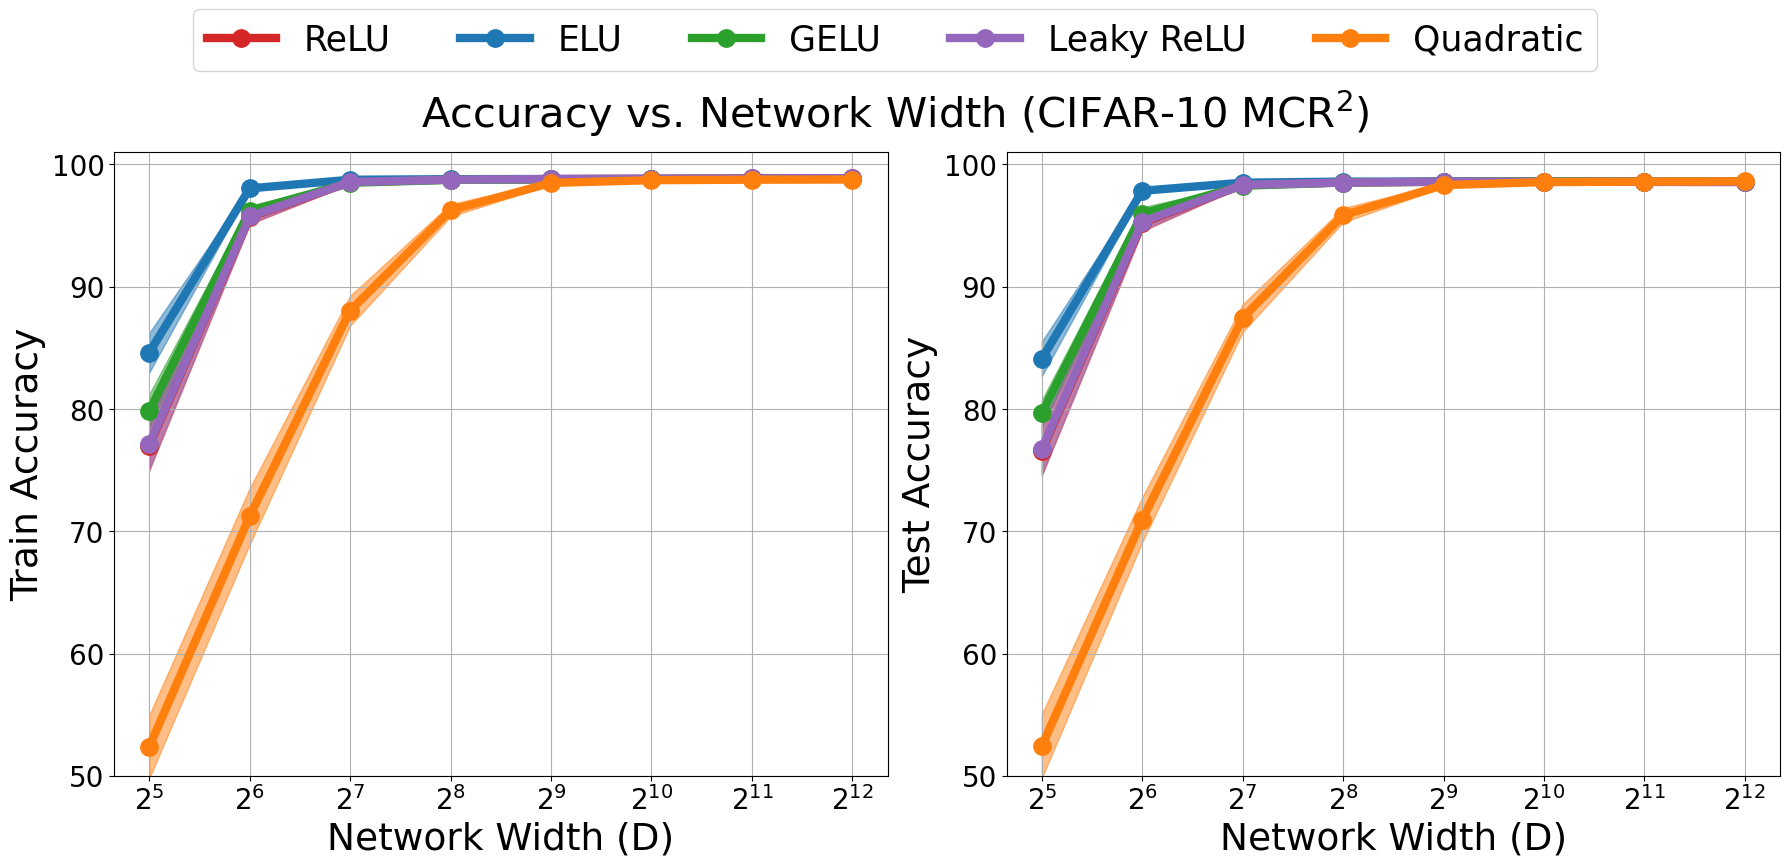

In [5]:
train_accs_mean = np.mean(train_accs, axis=0)
train_accs_std = np.std(train_accs, axis=0)

test_accs_mean = np.mean(test_accs, axis=0)
test_accs_std = np.std(test_accs, axis=0)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 8))

dim_base = int(np.log2(dim))
dim_save = str(dim)

start_idx = 1
lw = 6
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple', 'tab:orange'] 

# Plot training
ax1.set_xlabel(r'Network Width (D)', fontsize=27)
ax1.set_ylabel('Train Accuracy', fontsize=27)
#ax1.set_title('Accuracy vs. Network Width (d = ' + str(dim) + ', r = ' + str(rank) + ')', fontsize=22)

lns = []
for i in range(len(colors)):
    l_i = ax1.plot(widths, list(train_accs_mean[:, i]), color=colors[i], linewidth=lw, marker=".", markersize=25,
                  label=activations_save[activations[i]])
    ax1.fill_between(widths, list(train_accs_mean[:, i] - train_accs_std[:, i]), list(train_accs_mean[:, i] + train_accs_std[:, i]),
                    color=colors[i], alpha=0.5)
    lns += l_i

ax1.set_xscale('log', base=2)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

labs = [l.get_label() for l in lns]
#ax1.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5,1.20), ncol=5, fontsize=15)
ax1.grid()
ax1.set_ylim(50, 101)

# Plot testing
ax2.set_xlabel(r'Network Width (D)', fontsize=27)
ax2.set_ylabel('Test Accuracy', fontsize=27)
#ax2.set_title('Accuracy vs. Network Width (d = ' + str(dim) + ', r = ' + str(rank) + ')', fontsize=22)

lns = []
for i in range(len(colors)):
    l_i = ax2.plot(widths, list(test_accs_mean[:, i]), color=colors[i], linewidth=lw, marker=".", markersize=25,
                  label=activations_save[activations[i]])
    ax2.fill_between(widths, list(test_accs_mean[:, i] - test_accs_std[:, i]), list(test_accs_mean[:, i] + test_accs_std[:, i]),
                    color=colors[i], alpha=0.5)
    lns += l_i

ax2.set_xscale('log', base=2)
ax2.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)

labs = [l.get_label() for l in lns]
#ax2.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5,1.20), ncol=5, fontsize=15)
ax2.grid()
ax2.set_ylim(50, 101)

fig.suptitle('Accuracy vs. Network Width (CIFAR-10 MCR$^2$)', fontsize=30)
fig.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5,1.1), ncol=len(activations), fontsize=25)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Layer-wise feature compression & linear separability 

In [11]:
width = 1024
data_type = "cifar10"
num_layers = 7
num_nonlinear_layers1 = 6
num_nonlinear_layers2 = 3
K = 10

results_dir1 = "./save/hybrid/cifar10/width_" + str(width) + "_depth_" + str(num_layers) + "_nonlinear_depth_" + str(num_nonlinear_layers1) + "_" + str(K) + "_classes_relu_activation_seed_0"
results_dir2 = "./save/hybrid/cifar10/width_" + str(width) + "_depth_" + str(num_layers) + "_nonlinear_depth_" + str(num_nonlinear_layers2) + "_" + str(K) + "_classes_relu_activation_seed_0"

In [12]:
def find_threshold(s,  thresh=0.95):
    count = 0
    total = 0
    total_s = torch.sum(s)

    for i in range(len(s)):
        count += 1
        total += s[i]
        if total / total_s >= thresh:
            return count

In [29]:
interm_features1 = torch.load(os.path.join(results_dir1, "interm_features.pth"), map_location=torch.device('cpu'))
interm_features1 = interm_features1['interm_features']
rank_list1 = []

interm_features2 = torch.load(os.path.join(results_dir2, "interm_features.pth"), map_location=torch.device('cpu'))
interm_features2 = interm_features2['interm_features']
rank_list2 = []

for i in range(num_layers - 1):
    s1 = torch.linalg.svdvals(interm_features1[i])
    rank_list1.append(find_threshold(s1, thresh=0.95))
    
    s2 = torch.linalg.svdvals(interm_features2[i])
    rank_list2.append(find_threshold(s2, thresh=0.95))

print(rank_list1)
print(rank_list2)

[896, 868, 764, 552, 404, 377]
[896, 871, 805, 633, 475, 284]


In [23]:
interm_accs1 = np.zeros(num_layers - 1)
interm_accs2 = np.zeros(num_layers - 1)
for l in range(num_layers - 1):
    results1 = torch.load(os.path.join(results_dir1, "layer_" + str(l) + "_last.pth"), map_location=torch.device('cpu'))
    interm_accs1[l] = results1['train_accuracy']
    
    results2 = torch.load(os.path.join(results_dir2, "layer_" + str(l) + "_last.pth"), map_location=torch.device('cpu'))
    interm_accs2[l] = results2['train_accuracy']

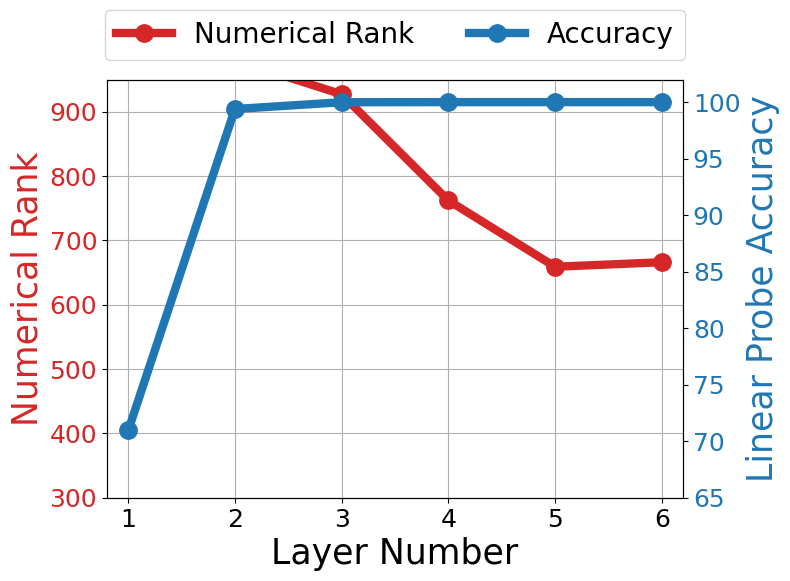

In [27]:
fig, ax1 = plt.subplots(figsize=(8,6))
#fig, ax1 = plt.subplots()
#fig.set_figheight(6)

start_idx = 1
lw = 6
color = 'tab:red'
ax1.set_xlabel(r'Layer Number', fontsize=25)
ax1.set_ylabel('Numerical Rank', fontsize=25, c=color)
l2 = ax1.plot(np.arange(start_idx, num_layers), rank_list1, color=color, linewidth=lw, marker=".", markersize=25,
              label="Numerical Rank")
ax1.tick_params(axis='y', labelcolor=color, labelsize=18)
ax1.set_xticks(np.arange(start_idx, num_layers), np.arange(start_idx, num_layers), fontsize=18)
ax1.set_xlim(0.8, num_layers-1+0.2)
plt.grid()
ax1.set_ylim(300, 950)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Linear Probe Accuracy', fontsize=25, c=color)  # we already handled the x-label with ax1
l4 = ax2.plot(np.arange(start_idx, num_layers), interm_accs1, color=color, marker=".", linewidth=lw, markersize=25,
          label="Accuracy")
ax2.tick_params(axis='y', labelcolor=color, labelsize=18)
#ax2.fill_between(np.arange(2,7), np.min(interm_accs1)-5, np.max(interm_accs1)+5, color="#7FFFD4", alpha=0.4)
#ax2.set_ylim(np.min(interm_accs1)-5, np.max(interm_accs1)+5)
ax2.set_ylim(65, 102)
lns = l2+l4
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5,1.20),
           ncols=2, fontsize=20)
#ax2.set_ylim(np.min(acc_list)-1, np.max(acc_list)+1)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

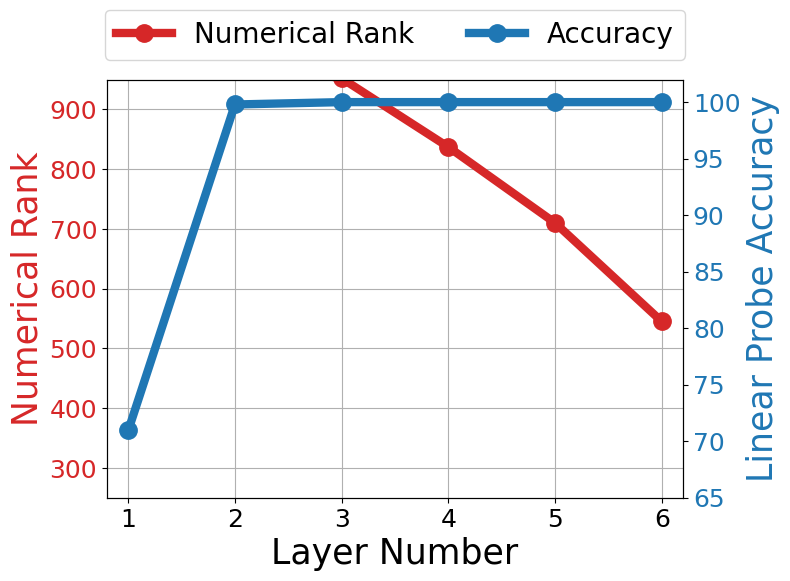

In [28]:
fig, ax1 = plt.subplots(figsize=(8,6))
#fig, ax1 = plt.subplots()
#fig.set_figheight(6)

start_idx = 1
lw = 6
color = 'tab:red'
ax1.set_xlabel(r'Layer Number', fontsize=25)
ax1.set_ylabel('Numerical Rank', fontsize=25, c=color)
l2 = ax1.plot(np.arange(start_idx, num_layers), rank_list2, color=color, linewidth=lw, marker=".", markersize=25,
              label="Numerical Rank")
ax1.tick_params(axis='y', labelcolor=color, labelsize=18)
ax1.set_xticks(np.arange(start_idx, num_layers), np.arange(start_idx, num_layers), fontsize=18)
ax1.set_xlim(0.8, num_layers-1+0.2)
plt.grid()
ax1.set_ylim(250, 950)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Linear Probe Accuracy', fontsize=25, c=color)  # we already handled the x-label with ax1
l4 = ax2.plot(np.arange(start_idx, num_layers), interm_accs2, color=color, marker=".", linewidth=lw, markersize=25,
          label="Accuracy")
ax2.tick_params(axis='y', labelcolor=color, labelsize=18)
#ax2.fill_between(np.arange(2,7), np.min(interm_accs1)-5, np.max(interm_accs1)+5, color="#7FFFD4", alpha=0.4)
#ax2.set_ylim(np.min(interm_accs1)-5, np.max(interm_accs1)+5)
ax2.set_ylim(65, 102)
lns = l2+l4
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5,1.20),
           ncols=2, fontsize=20)
#ax2.set_ylim(np.min(acc_list)-1, np.max(acc_list)+1)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()